##  Reproducing Genetic Algorithm Generated CNC Cutting Parameters with a Neural Network

### Introduction

This notebook aims to reproduce the output data of *Multi-Objective Optimization of Turning Process during Machining of AlMg1SiCu (Aluminum) Using Non-Dominated Sorted Genetic Algorithm* by Rahul Dhabalea, VijayKumar S. Jattib, and T.P.Singhc. The study used a genetic algorithm (GA) to generate novel cutting parameters and predict material removal rate & surface roughness. The study can be found [here](https://www.sciencedirect.com/science/article/pii/S2211812814005318) for further reading but some explanation will follow, mainly concerning the differences between goals and the methodology used in creating the artificial neural network (ANN).

### Background

The GA used twenty-seven rows of input data that are a series of test cuts where a CNC machine tool was set to turn a constant diameter with a range of spindle speeds (rpm), feed rates (mm/rev), and depths of cut(mm). The results of each test cut take the form of a calculated material remove rate (mm$^3$/min) and surface roughness (μm) measurement. Their goal was to have the GA produce cutting conditions and results which maximized material removal rate and minimized surface roughness. These two outcomes are conflicting in nature and so result in one ideal output for each scenario. In total the GA generated and ranked sixteen suggestions. Five of the sixteen results were chosen for validation of the GA results and tested on the CNC machine. The results had an average of less than five percent error from the forecast. 

### This Notebook

The major difference between the study and this notebook, besides the algorithm used, is in the prediction method. The ANN will be designed to accept a desired surface roughness as an input, and generate the spindle speed, feed rate, and depth of cut as outputs. The initial twenty-seven rows will be used as training data, while the five rows used for validation in the study will be split into four rows of testing data and one row for validation. The single row kept for validation will have the lowest surface roughness value in the entire dataset. This makes for a more realistic test of the ANN because an end user would be requesting results that are better than the initial test cuts and this input data will be outside anything the ANN has been trained on which makes for a more difficult prediction. 

### Details

Usually a dataset's features very widely between magnitude, units, and range. For this reason, it's important to scale the data because most machine learning models recognize patterns using Euclidian distance between any two points. There are many ways to scale data but, in this notebook, the Standard method in the Scikit-Learn library will be applied. In the initial tests the MinMax scaler was also used, with both scaled data sets used with the Talos package to tune the hyperparameters of the neural network. The best results of each were applied to the Keras model for final results on the validation data. It was found for this problem the Standard scaler far surpassed the MinMax scaler, so it has been removed from the notebook. The material removal rate data, although having a higher linear correlation to the three outputs, was causing a worse model prediction when included and was dropped from the data before training. This is a simple calculated field so there is no need in "predicting" its value anyway. 

### Conclusion

This notebook was made to show the feasibility in using a neural network, made with common open source tools, to facilitate process improvements in manufacturing by replicating the successful results of a GA and adjusting the input and output parameters to create a tool useful for the shop floor.

Test cuts of this nature will likely produce a very small amounts of data as seen in the study. Generally, in machine learning a much larger amount of data is required for a robust model to be created, that shortcoming can be seen here with the model's graphed validation accuracy and loss, but it appears an acceptable level of performance is achievable if enough domain knowledge around the data being collected can be applied and it's wrangled correctly. The predicted values show a much higher level of accuracy and consistency than the model's scoring during creation.

The final model is scores between 6 and 8 average percent error across the three predictions, with the RPM and feedrate consistently closer 5% and the depth of cut ranging between 10 to 15%. The fluctuation seen between model runs is caused by weights and bias in the ANN be itialized from zero at every start. The final predicted values and percent error can be seen below the graphs at the end of the notebook.

Other cutting or result data would likely need to be used to fit a real business model, for instance replacing material removal rate with some measure of process stability like tool life or "time since adjustment", but due to the proprietary nature of manufacturing the availably of real-world data is limited.

In [420]:
# import dependencies
%matplotlib inline
import keras
from keras.models import Sequential
from keras.activations import *
from keras.callbacks import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.layers import advanced_activations
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import talos as ta
import warnings
warnings.filterwarnings("ignore")

# establish fixed seeding for reproducability
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# suppress NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

# print the version of each library being used for reproducability
print('Dependency Version:\n')
print('Keras', keras.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', seaborn.__version__)
print('Sklearn', sklearn.__version__)
print('Talos', ta.__version__)

Dependency Version:

Keras 2.2.4
Numpy 1.17.0
Pandas 0.24.2
Seaborn 0.9.0
Sklearn 0.20.3
Talos 0.6.0


In [421]:
# import data
data = pd.read_csv('data.txt', delim_whitespace=True, encoding='ISO-8859-1')
# look at the dataframe
data

,Sr._No.,Spindle_speed(rpm),Feed_rate(mm/rev),Depth_of_cut(mm),MRR(mm3/min),Ra(µm)
0,1,280,0.0508,0.40,306.67,0.36
1,2,280,0.0508,0.80,609.76,0.47
2,3,280,0.0508,1.20,909.28,0.52
3,4,280,0.1016,0.40,582.94,0.80
4,5,280,0.1016,0.80,1158.73,0.90
5,6,280,0.1016,1.20,1727.36,1.10
6,7,280,0.1524,0.40,943.34,1.63
7,8,280,0.1524,0.80,1875.96,1.76
8,9,280,0.1524,1.20,2797.84,2.17
9,10,710,0.0508,0.40,793.04,0.38


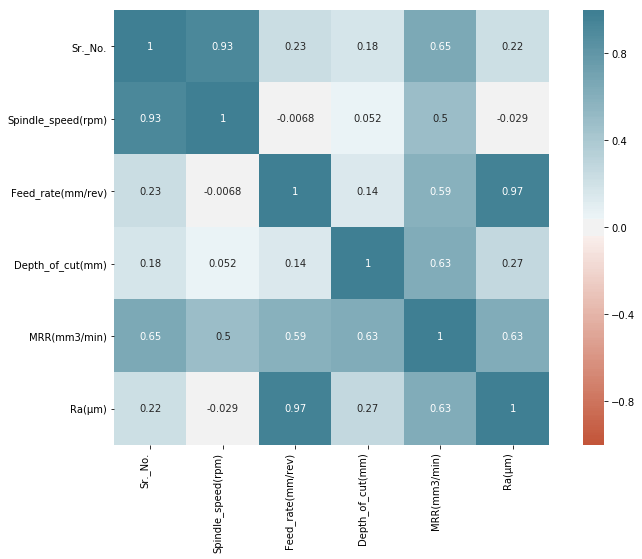

In [422]:
# a look at the overall correlation of each feature in the raw data
heat_data = data
plt.figure(figsize=(12, 8))
corr = heat_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig('heatmap')

In [423]:
# drop the index number of the tests
data.drop(columns=['Sr._No.', 'MRR(mm3/min)'], inplace=True)

In [424]:
# create a NumPy array from the DataFrame
np_data = data.values

In [425]:
# Standardize features by removing the mean and scaling to unit variance
Standard_scaler = StandardScaler()
np_data_Standard = Standard_scaler.fit_transform(np_data)

In [426]:
# split the scaled Standard data into training, testing, and validation sets
train_features_Standard = np_data_Standard[0:27 , 3:4]
test_features_Standard = np_data_Standard[28:32, 3:4]
validation_features_Standard = np_data_Standard[27, 3:4]
train_labels_Standard = np_data_Standard[0:27, 0:3]
test_labels_Standard = np_data_Standard[28:32, 0:3]
validation_labels_Standard = np_data_Standard[27, 0:3]

# reshape the validation data because it's only one row
validation_features_Standard = validation_features_Standard.reshape(1, -1)
validation_labels_Standard = validation_labels_Standard.reshape(1, -1)

In [436]:
print(train_features_Standard.shape)
print(train_labels_Standard.shape)
print(test_features_Standard.shape)
print(test_labels_Standard.shape)
print(validation_features_Standard.shape)
print(validation_labels_Standard.shape)

(27, 1)
(27, 3)
(4, 1)
(4, 3)
(1, 1)
(1, 3)


In [ ]:
# Define the Standard model using the top performing parameters from Talos
Standard_model = Sequential()
Standard_model.add(Dense(8, input_dim=1, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(56, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(40, activation='relu'))
Standard_model.add(Dense(32, activation='relu'))
Standard_model.add(Dense(24, activation='relu'))
Standard_model.add(Dense(16, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

history = Standard_model.fit(train_features_Standard,
                             train_labels_Standard,
                             validation_data=(test_features_Standard, test_labels_Standard),
                             batch_size=20,
                             epochs=1000,)

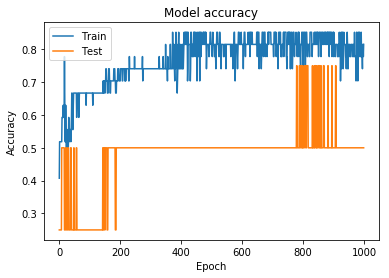

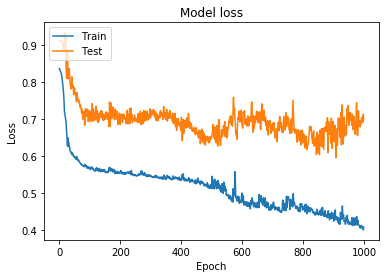

In [430]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [435]:
# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
validation_prediction = np.concatenate([prediction, validation_features_Standard], axis=1)
validation = Standard_scaler.inverse_transform(validation_prediction)
# compare
print('\nValidation input data (desired Ra):\n\n', validation[:, 3])
print('\nTrue validation output data (RPM, Feed, DOC):\n\n', np_data[27, 0:3])
print('\nPredicted output data (RPM, Feed, DOC):\n\n', validation[:, 0:3])


Validation input data (desired Ra):

 [0.21]

True validation output data (RPM, Feed, DOC):

 [1100.      0.05    0.4 ]

Predicted output data (RPM, Feed, DOC):

 [[1161.96267346    0.04859314    0.35699389]]


In [432]:
Standard_rpm_error = ((np_data[27, 0:3][0] - validation[0][0])/np_data[27, 0:3][0])*100
Standard_feed_error = ((np_data[27, 0:3][1] - validation[0][1])/np_data[27, 0:3][1])*100
Standard_doc_error = ((np_data[27, 0:3][2] - validation[0][2])/np_data[27, 0:3][2])*100
Standard_average_error = (np.absolute(Standard_rpm_error) + np.absolute(Standard_feed_error) + np.absolute(Standard_doc_error)) / 3

print('\nPercent Errors:\n')
print('RPM : ', np.absolute(Standard_rpm_error))
print('Feed rate : ', np.absolute(Standard_feed_error))
print('Depth of cut : ', np.absolute(Standard_doc_error))
print('Average : ', Standard_average_error)


Percent Errors:

RPM :  5.632970314748449
Feed rate :  2.8137266857802685
Depth of cut :  10.751526752090387
Average :  6.399407917539701
